# Theoretic part (20 pts, 5 pts each)

Multiple choice questions: please select all that applies and explain your answer.

### Question 1 (Autocorrelation). 
The autocorrelation plot of the daily time-series has local peaks at t=7,14,21,28 etc.. How would you interpret that?

A. The time-series reaches its maximum on the days 7,14,21,28...

B. The time-series reaches its minimum on the days 7,14,21,28...

C. The time-series is likely to have a periodic pattern with a period of 7 days

D. The time-series is likely to have 7 periods per day

E. The appropriate AR model for the time-series should have at least 7 terms.

C

we cannot determine the maximum or minimum on the days when daily time-series has local peaks


### Question 2 (Stationarity).

Which of the following time-series models are stationary:

A. Linear trend

B. AR(1) model

C. White noise

D. Random walk

E. ARMA(1,2) model

F. ARIMA(1,1,1) model

B C E

A stationary time series is one whose properties do not depend on the time at which the series is observed. 

A stationary time series will have no predictable patterns in the long-term

### Question 3 (PCA). 
Which of the following statements regarding the model dimensionality reduction through Principal Component Analysis (PCA) are true:

A. Leading principal components of the features are the most efficient for modeling the output variable.

B. Principal components of the standardized features are uncorrelated and this way less exposed to multicollinearity.

C. The model using principal components of the features can't overfit.

D. Feature selection based on the principal components of the features is often more efficient in preventing overfitting comparered the feature selection over the original features.

E. Principal components are harder to interpret compared to the original features making the PCA regresssion model less interpretable compared to the regression model using original features.

B D E


The model using principal components of the features sometimes can overfit.

### Question 4 (MapReduce). 

What is true about MapReduce:

A. MapReduce is a Python module enabling parallel computing

B. Using MapReduce approach makes the code more suitable for parallel computing.

C. MapReduce code always runs faster compared to the code using more traditional approaches, like loops or list comprehensions.

D. MapReduce code will always efficiently run on multiple cores of you CPU or multiple machines within your cluster if available.

E. Multiprocessing and PySpark efficient alternatives to MapReduce.



B C D

MapReduce is a programming module enabling parallel computing

If the data is too big to fit entirely into memory, then Spark could suffer major performance degradations

# Practice part: Taxi ridership from JFK to other taxi zones prediction.
This project is an example of applying PCA to predict hourly yellow taxi ridership at the taxi zone level. Modeling taxi ridership at a fine spatial and temporal granularity is challenging due to the low signal-to-noise ratio and high dimensionality. In this case, dimension reduction is essential in feature engineering. This project has five steps: data downloading, data preprocessing, baseline modeling, feature engineering, and RandomForest modeling.

Let's start with data downloading. 

## 1. Data downloading (5pts)
Design a function to download yellow taxi data from 2017-01-01 to 2018-12-31 at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.

In [2]:
from sklearn import metrics
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.decomposition import PCA  ## sklearn PCA classes
from sklearn.decomposition import KernelPCA
from sklearn import linear_model    ## sklearn linear model
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import scipy
import dask_ml
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import linear_model    ## sklearn linear model
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [5]:
def data_downloading(year):
    for month in range(1,13):
        if month < 10:
            path = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + str(year)+"-0"+str(month)+".csv"
        else :
            path = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + str(year)+"-"+str(month)+".csv"
        data = pd.read_csv(path)
        data.to_csv( "./data/" + str(year) + "_" + str(month)+".csv",index = False)
        print("year: ",year)
        print("month: ",month)
data_downloading(2017)
data_downloading(2018)

year:  2017
month:  1
year:  2017
month:  2
year:  2017
month:  3
year:  2017
month:  4
year:  2017
month:  5
year:  2017
month:  6
year:  2017
month:  7
year:  2017
month:  8
year:  2017
month:  9
year:  2017
month:  10
year:  2017
month:  11
year:  2017
month:  12
year:  2018
month:  1
year:  2018
month:  2
year:  2018
month:  3
year:  2018
month:  4
year:  2018
month:  5
year:  2018
month:  6
year:  2018
month:  7
year:  2018
month:  8
year:  2018
month:  9
year:  2018
month:  10
year:  2018
month:  11
year:  2018
month:  12


## 2. Data Preprocessing (10 pts, 7 for dask, 3 for sanity check)
Use dask to aggregate all months' records into one dataframe, and aggregate dataset by date and hour to get the ridership from JFK to each taxi zone each hour. The expected output has columns: date, hour, drop-off location 1, drop-off location 2, etc. 

Hint: 
1. JFK taxi zone id is 132.
2. time column should be the pickup time, and ridership is passenger count.
3. Try read_csv("*.csv") to read all csv file in a folder 
4. files in 2017 and 2018 have different columns; apply argument usecols to select desired columns.
5. using .compute() function to convert processed dask dataframe to pandas dataframe for further modeling.

### 2.1 Data loading

In [6]:
df = dd.read_csv('./data/*.csv', usecols = ['tpep_dropoff_datetime','tpep_pickup_datetime',
                                           'passenger_count','PULocationID','DOLocationID',
                                           ],
                                 dtype={'trip_distance': float,'total_amount': float, 'RatecodeID': float,
                                        'VendorID': float, 'passenger_count': float, 'payment_type':float, 
                                            'PULocationID':int, 'DOLocationID':int},
                                 )
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
0,2017-01-09 11:13:28,2017-01-09 11:25:45,1.0,263,161
1,2017-01-09 11:32:27,2017-01-09 11:36:01,1.0,186,234
2,2017-01-09 11:38:20,2017-01-09 11:42:05,1.0,164,161
3,2017-01-09 11:52:13,2017-01-09 11:57:36,1.0,236,75
4,2017-01-01 00:00:00,2017-01-01 00:00:00,1.0,249,234


### 2.2 Sanity check
Then, we need to do some basic sanity checks. It is possible that in a particular hour, there were no yellow taxis dispatched from JFK. Check if each day has 24-hour records and add missing records to the dataframe. The final output should have 17520 rows ($365\times2\times24$)

In [7]:
# JFK
df = df[df['PULocationID'] == 132]

#convert columns to datetime dtype
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Year / Hour/ DayOfYear
df['year'] = df['tpep_pickup_datetime'].dt.year
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_year'] = df['tpep_pickup_datetime'].dt.dayofyear

group_df_d_y_h = df.groupby(['day_of_year','year','hour'])['passenger_count'].sum().reset_index().compute()

In [8]:
norm_df = pd.DataFrame(index=pd.MultiIndex.from_product
        (
            [
                range(1,366),
                [2017,2018],
                range(1,25)
            ]
        ))

norm_df = norm_df.reset_index()
norm_df.columns = ['day_of_year','year','hour']
final_df = pd.merge(norm_df,group_df_d_y_h,how = 'left', on = ['day_of_year','year','hour'])
final_df

,day_of_year,year,hour,passenger_count
0,1,2017,1,247.0
1,1,2017,2,105.0
2,1,2017,3,76.0
3,1,2017,4,46.0
4,1,2017,5,309.0
...,...,...,...,...
17515,365,2018,20,661.0
17516,365,2018,21,766.0
17517,365,2018,22,728.0
17518,365,2018,23,562.0


## 3. Time-series exploratory analysis
Apply exploratory analysis over the daily aggregated dataset at first.

### 3.1 aggregate the ridership from each dropoff location and sum it to get daily records. (3pts)

In [9]:
df['date_y_m_d'] = df['tpep_pickup_datetime'].dt.strftime("%Y-%m-%d")
group_df_date = df.groupby(['date_y_m_d'])['passenger_count'].sum().reset_index().compute()
group_df_date

,date_y_m_d,passenger_count
0,2017-01-01,14710.0
1,2017-01-14,11353.0
2,2017-01-15,12507.0
3,2017-01-16,15063.0
4,2017-01-31,10004.0
...,...,...
733,2018-09-25,11454.0
734,2018-09-26,11076.0
735,2018-09-27,12616.0
736,2018-09-28,12507.0


In [10]:
group_df_date['year'] = pd.to_datetime(group_df_date['date_y_m_d']).dt.year
group_df_date_2017 = group_df_date.loc[group_df_date['year'] == 2017].sort_values(by = 'date_y_m_d')
group_df_date_all = group_df_date.loc[(group_df_date['year'] == 2017) |
                                      (group_df_date['year'] == 2018)].sort_values(by = 'date_y_m_d')

In [11]:
sub_df_2017 = group_df_date_2017.reset_index()
sub_df_all = group_df_date_all.reset_index()

### 3.2 Period detection and report the strongest period length on the 2017 data. (3pts)
Hint: using periodogram or acf plot.

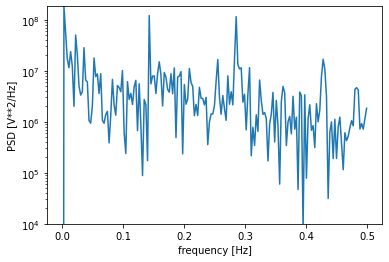

In [12]:
f, PSD = scipy.signal.periodogram(sub_df_2017['passenger_count'], 1)
plt.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim(10**4,max(PSD))
plt.show()

The strongest period is detected at the frequency around 1/7, corresponding to one week.

### 3.3 Trend, seasonality, noise decomposition (using additive model) on 2017 data, period is from question 3.2 (3 pts)

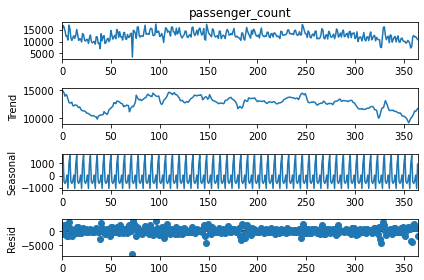

In [13]:
daySeries = sub_df_2017['passenger_count']
dailyDecomp = seasonal_decompose(daySeries, model='additive', period = 7, extrapolate_trend='freq')
fig = dailyDecomp.plot()

## 4. Predict the total daily ridership from JFK using ARIMA.
ARIMA is a common method to predict taxi ridership. Before we predict taxi zone level hourly ridership, let's try to predict the aggregated daily ridership using ARIMA.

### 4.1 Using adfuller test to test the stability of the aggregated dataset. If not stable, apply differencing method until the p-value from adfuller test is smaller than 0.05. (3pts)

In [14]:
from statsmodels.tsa.stattools import adfuller

series= sub_df_all['passenger_count']
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.153267
p-value: 0.223642
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


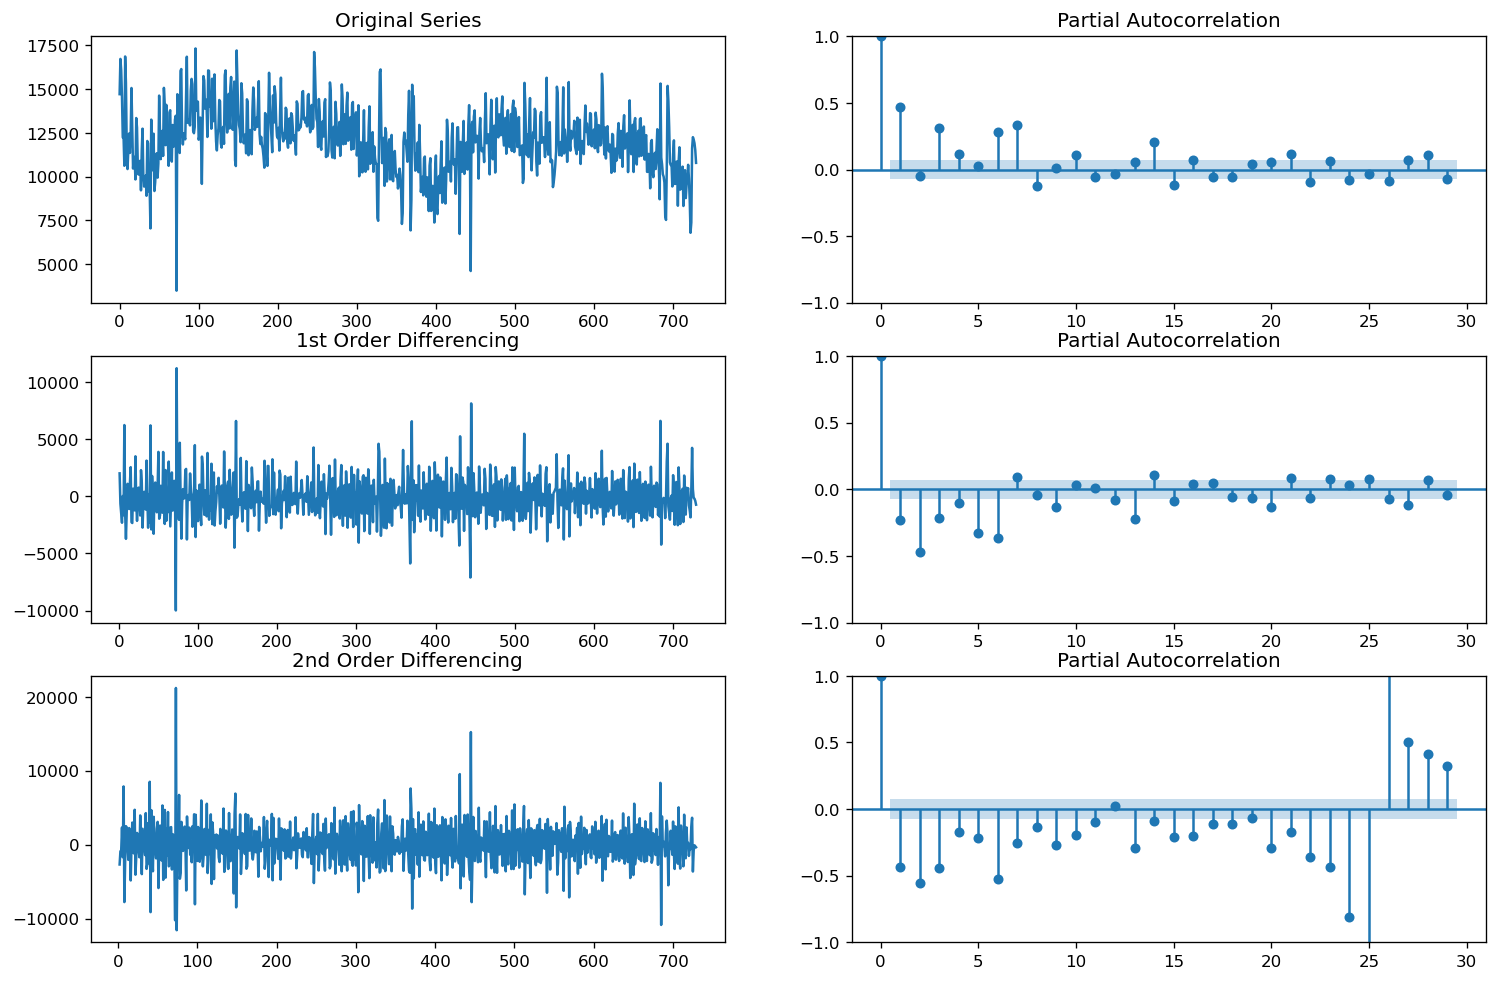

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(sub_df_all['passenger_count']); axes[0, 0].set_title('Original Series')
plot_pacf(sub_df_all['passenger_count'], ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')

# 1st Differencing
axes[1, 0].plot(sub_df_all['passenger_count'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(sub_df_all['passenger_count'].diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')

# 2nd Differencing
axes[2, 0].plot(sub_df_all['passenger_count'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(sub_df_all['passenger_count'].diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

In [16]:
# raw
series=sub_df_all['passenger_count']#.diff()
result = adfuller(series.dropna())
print('raw observations:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])


# first order differencing
series=sub_df_all['passenger_count'].diff()
result = adfuller(series.dropna())
print('\n1st order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

# second order differencing
series=sub_df_all['passenger_count'].diff().diff()
result = adfuller(series.dropna())
print('\n2nd order differencing:')
print('  ADF Statistic: %f' % result[0])
print('  p-value: %f' % result[1])

raw observations:
  ADF Statistic: -2.153267
  p-value: 0.223642

1st order differencing:
  ADF Statistic: -8.182330
  p-value: 0.000000

2nd order differencing:
  ADF Statistic: -12.230395
  p-value: 0.000000


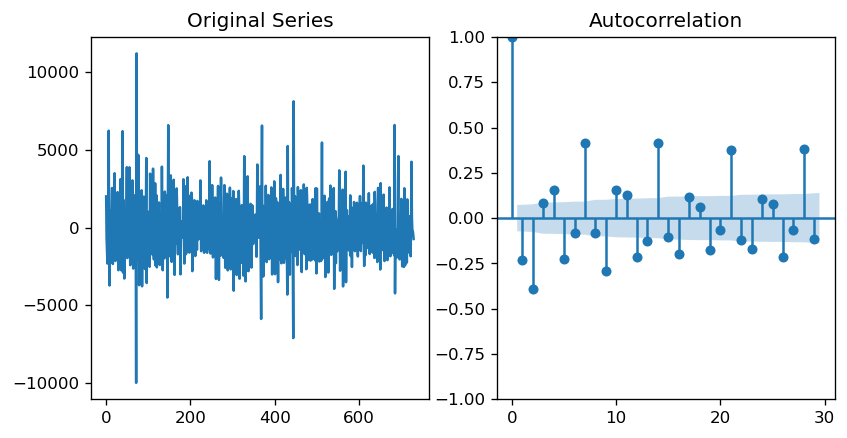

ADF Statistic: -8.182330
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [17]:
sub_df_all['passenger_count_diff'] = sub_df_all['passenger_count'].diff()
fig, axes = plt.subplots(1, 2,figsize=(8,4))
axes[0].plot(sub_df_all['passenger_count_diff'])
axes[0].set_title('Original Series')
plot_acf(sub_df_all['passenger_count_diff'].dropna(), ax=axes[1])
plt.show()

series=sub_df_all['passenger_count_diff']
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

### 4.2 Find out proper AR and MA terms in an ARIMA model using pacf and acf plots. (4 pts, 2 for each plot)
Hint: positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. In general, differencing reduces positive autocorrelation and may even cause a switch from positive to negative autocorrelation. 

Identifying the numbers of AR and MA terms:
1. if the pacf plot shows a sharp cutoff and/or the lag-1 autocorrelation is positive then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

2. if the acf plot displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

3. It is generally advisable to stick to models in which at least one of AR and MA term is no larger than 1, i.e., do not try to fit a model such as ARIMA(2,1,2).

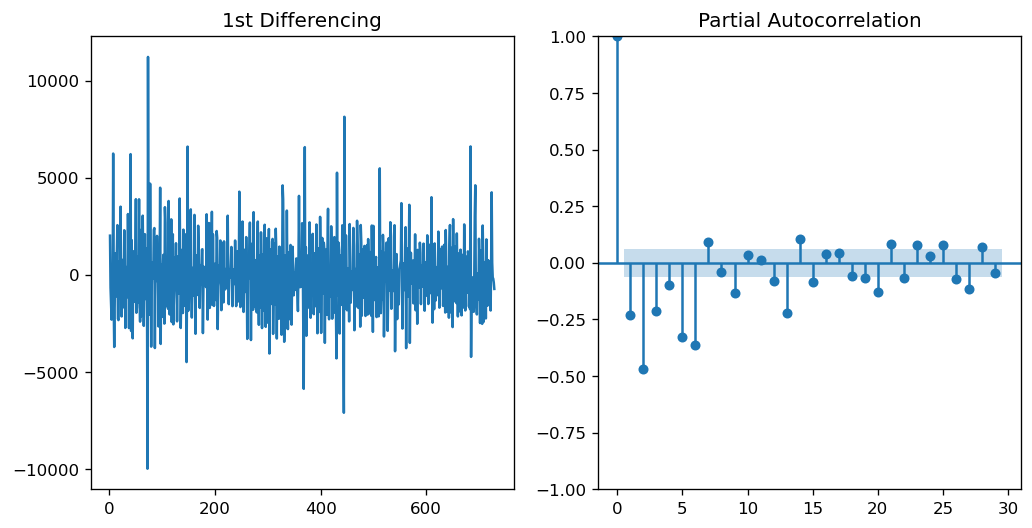

In [18]:
# AR / q
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(sub_df_all['passenger_count_diff'])
axes[0].set_title('1st Differencing')
# axes[1].set_ylim(0,1)
plot_pacf(sub_df_all['passenger_count_diff'].dropna(), ax=axes[1],alpha=0.1) #plot differences between consequtive observations

plt.show()

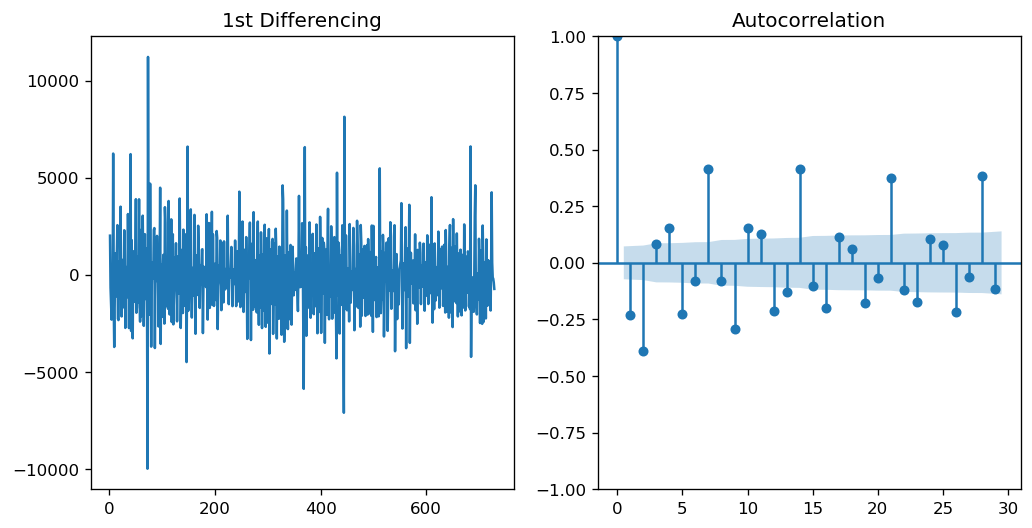

In [19]:
# MA / p
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(sub_df_all['passenger_count_diff']); axes[0].set_title('1st Differencing')
plot_acf(sub_df_all['passenger_count_diff'].dropna(), ax=axes[1])

plt.show()

### 4.3 build an ARIMA model using terms from 4.2, training on the first 700 days, forecast on the last 31 days. Print ARIMA model results and plot in-sample and out-of-sample prediction in different colors. (8 pts, 3 for correct terms, 3 for training and summary, 2pts for the plot)

                                SARIMAX Results                                 
Dep. Variable:     passenger_count_diff   No. Observations:                  699
Model:                   ARIMA(2, 1, 1)   Log Likelihood               -6157.321
Date:                  Sat, 12 Mar 2022   AIC                          12322.643
Time:                          12:15:39   BIC                          12340.836
Sample:                               0   HQIC                         12329.676
                                  - 699                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3428      0.023    -14.601      0.000      -0.389      -0.297
ar.L2         -0.4678      0.029    -16.386      0.000      -0.524      -0.412
ma.L1         -0.9999      0.034    

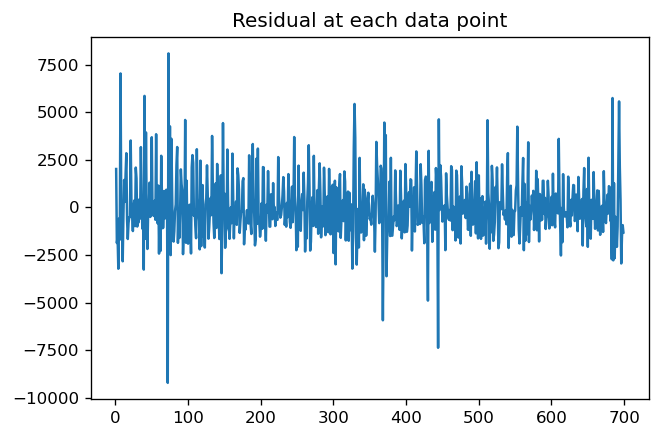

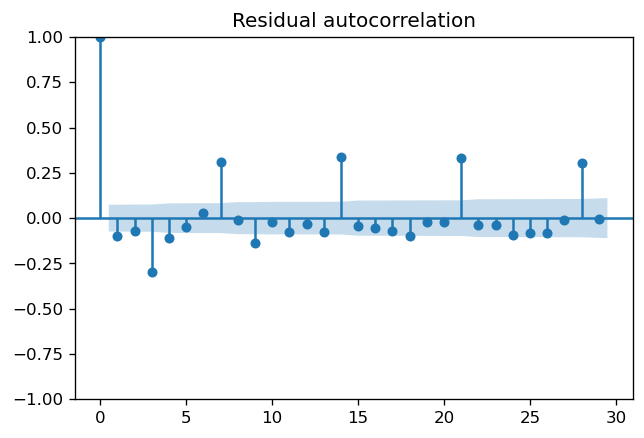

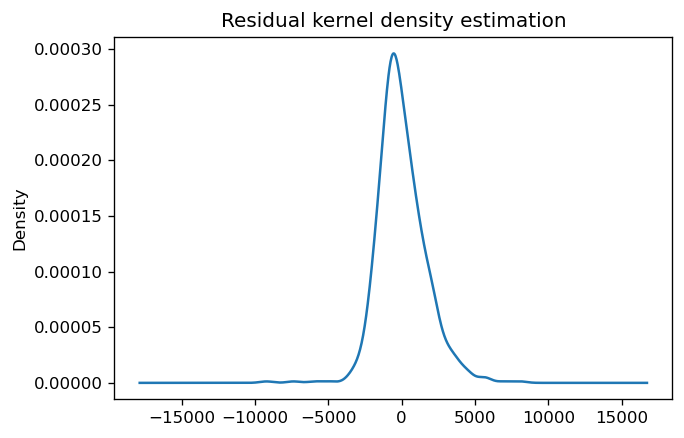

                 0
count   699.000000
mean     25.666307
std    1645.785292
min   -9215.981435
25%    -982.079336
50%    -223.649148
75%     875.081305
max    8083.214094
p value is  8.257753077625413e-18
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected
Ljung–Box:
       lb_stat     lb_pvalue
1     7.145130  7.516784e-03
2    10.555909  5.102857e-03
3    73.155317  9.003414e-16
4    82.030777  6.466235e-17
5    83.585397  1.489938e-16
6    84.208910  4.814104e-16
7   151.000605  2.502399e-29
8   151.103020  1.154331e-28
9   163.978465  1.105961e-30
10  164.311449  4.168332e-30


In [20]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=1
D=1
Q=2

# fit model
N= 700
series = sub_df_all['passenger_count_diff']#.values

model = sm.tsa.ARIMA(series[:N].dropna(), order=(Q,D,P))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
    
print("Ljung–Box:")
print(sm.stats.acorr_ljungbox(residuals))

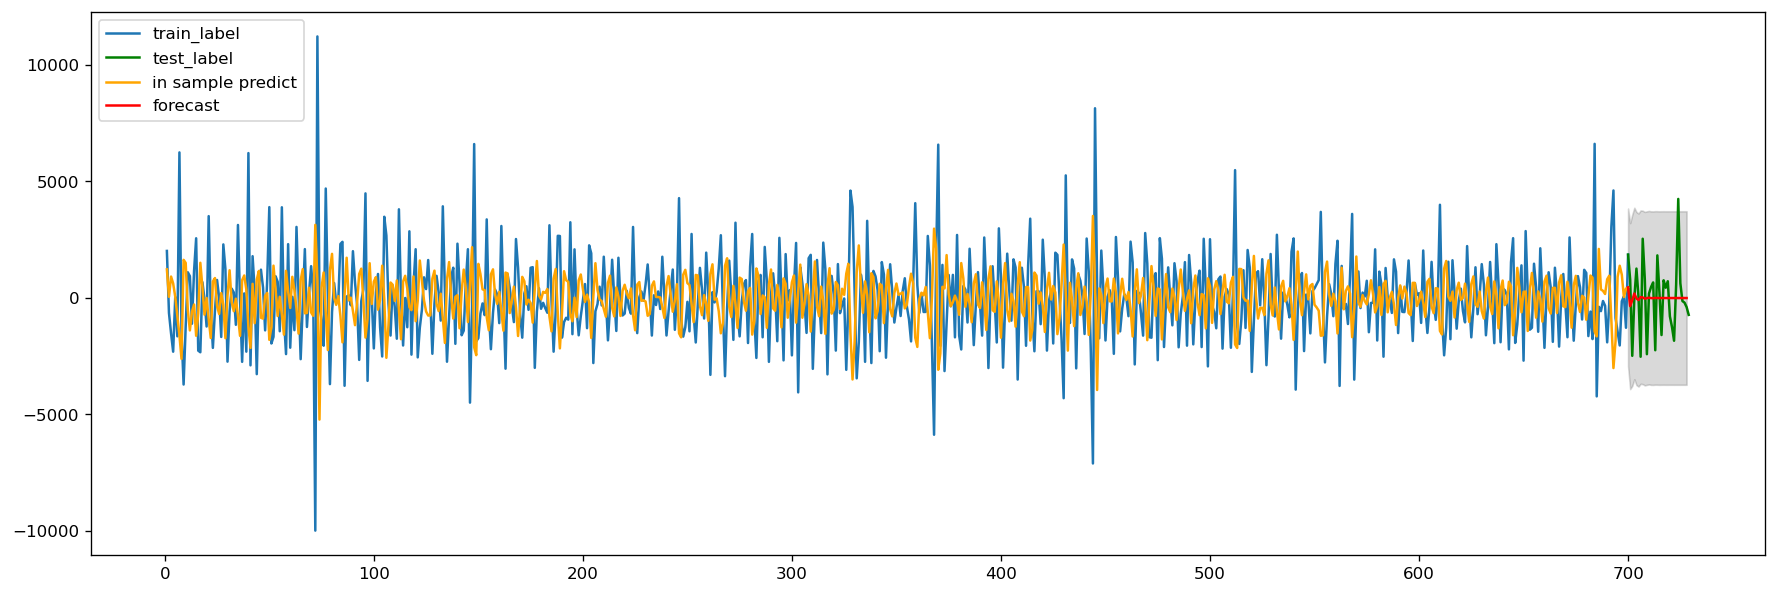

In [21]:
# Forecast

fcast = model_fit.forecast(steps=len(series)-N)  # 95% conf
fc = model_fit.get_forecast(steps=len(series)-N).summary_frame()

fc_series = pd.Series(fc['mean'], index=range(N,len(series)))
#mean_series = pd.Series(fc['mean'], index=range(N,len(series)))
lower_series = pd.Series(fc.mean_ci_lower, index=range(N,len(series)))
upper_series = pd.Series(fc.mean_ci_upper, index=range(N,len(series)))

plt.rcParams.update({'figure.figsize':(18,6)})
fig, ax = plt.subplots()
ax.plot(sub_df_all.index[:N+1],series[:N+1],label='train_label') # train
ax.plot(sub_df_all.index[N:],series[N:],color='green',label='test_label') # test
ax.plot(sub_df_all.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.fill_between(sub_df_all.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
ax.legend(loc='upper left')

# Taxi zone level prediction

This project aims to predict hourly yellow taxi ridership volume from JFK to each taxi zone. The ARIMA experiment in section 3 forecasts the total ridership amount from JFK. However, based on the reported $R^2$, this model is not a good fit. ARIMA model has four main shortcomings: 1) they rely heavily on stationarity assumption which does not hold in real-world traffic systems 2) they do not consider spatial and structural dependencies that traffic networks exhibit and forecast each sensor as an individual time series 3) they are unable to model non-linear temporal dynamics 4) they suffer from the curse of dimensionality. Due to the limitation of ARIMA, we need to apply another method to predict taxi zone level ridership.

## 5. Feature engineering

Our workflow is first standardizing the dataset, then using PCA to compress the dataset. As we predict future ridership, PCA should be learned from historical data (2017) then apply to the following year (2018). Next, add lag features (PCA components) from the past 12 hours and apply a Random Forest regressor to predict each PCA component's values in the next hour. After we had the PCA component prediction, inverse PCA, and inverse standardization to retrieve taxi ridership prediction in its original scale and dimension, in other words, we are predicting the PCA components instead of taxi zone level ridership and then using the inverse PCA method to reconstruct 

### 5.1. standardization. (3 pts)
The standardscaler stores information of this standardization process, including the mean and standard deviation values required when converting the prediction back to the raw scale. Split the whole dataset into two parts: 2017 and 2018, standardize each separately.

In [22]:
all_df = dd.read_csv('./data/*.csv',usecols = ['tpep_pickup_datetime','passenger_count',
                                               'PULocationID','DOLocationID',"trip_distance",
                                               "tip_amount",'fare_amount','total_amount'
                                           ],
                     dtype={'trip_distance': float,'total_amount': float, 'RatecodeID': float,
                                        'VendorID': float, 'passenger_count': float, 'payment_type':float, 
                                            'PULocationID':int, 'DOLocationID':int}, )
all_df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount
0,2017-01-09 11:13:28,1.0,3.30,263,161,12.5,2.00,15.30
1,2017-01-09 11:32:27,1.0,0.90,186,234,5.0,1.45,7.25
2,2017-01-09 11:38:20,1.0,1.10,164,161,5.5,1.00,7.30
3,2017-01-09 11:52:13,1.0,1.10,236,75,6.0,1.70,8.50
4,2017-01-01 00:00:00,1.0,0.02,249,234,52.0,0.00,52.80


In [23]:
# JFK
all_df = all_df[all_df['PULocationID'] == 132]
# convert datetime
all_df['tpep_pickup_datetime'] = dd.to_datetime(all_df['tpep_pickup_datetime'])
all_df['date_m_d'] = all_df['tpep_pickup_datetime'].dt.strftime("%m-%d")
all_df['day_of_year'] = all_df['tpep_pickup_datetime'].dt.dayofyear

# Year / Hour 
all_df['year'] = all_df['tpep_pickup_datetime'].dt.year
all_df['hour'] = all_df['tpep_pickup_datetime'].dt.hour

In [24]:
group_df_day_year_hour = all_df.groupby(['day_of_year','year','hour'])[['passenger_count','tip_amount',
                                                                        'fare_amount', 'trip_distance']].sum().reset_index().compute()
group_df_day_year_hour

,day_of_year,year,hour,passenger_count,tip_amount,fare_amount,trip_distance
0,1,2017,0,527.0,1101.03,10574.50,3713.70
1,1,2017,1,247.0,561.88,4947.50,1765.74
2,1,2017,2,105.0,160.56,2095.00,680.62
3,1,2017,3,76.0,109.04,1436.50,497.94
4,1,2017,4,46.0,56.77,770.00,223.41
...,...,...,...,...,...,...,...
17538,273,2018,16,792.0,3562.98,24520.76,8439.84
17539,273,2018,17,993.0,3975.37,30658.75,10369.67
17540,273,2018,19,1013.0,4375.64,28948.00,9979.01
17541,273,2018,20,1008.0,4503.72,30895.06,10714.37


In [25]:
norm_df = pd.DataFrame(index=pd.MultiIndex.from_product
        (
            [
                range(1,366),
                [2017,2018],
                range(1,25)
            ]
        ))

norm_df = norm_df.reset_index()
norm_df.columns = ['day_of_year','year','hour']
group_df_day_year_hour = pd.merge(norm_df,group_df_day_year_hour,how = 'left', on = ['day_of_year','year','hour'])

In [26]:
group_df_day_year_hour.fillna(0,inplace  = True)
group_df_day_year_hour

,day_of_year,year,hour,passenger_count,tip_amount,fare_amount,trip_distance
0,1,2017,1,247.0,561.88,4947.50,1765.74
1,1,2017,2,105.0,160.56,2095.00,680.62
2,1,2017,3,76.0,109.04,1436.50,497.94
3,1,2017,4,46.0,56.77,770.00,223.41
4,1,2017,5,309.0,888.24,6935.50,2334.88
...,...,...,...,...,...,...,...
17515,365,2018,20,661.0,2307.55,16278.00,5767.63
17516,365,2018,21,766.0,3270.10,21250.46,7421.63
17517,365,2018,22,728.0,2472.73,17662.50,6286.49
17518,365,2018,23,562.0,2161.99,14865.00,5227.19


In [27]:
def feature_extract(df):
    df_2017 = df.loc[df['year'] == 2017]
    df_2018 = df.loc[df['year'] == 2018]
    # y
    y_2017 = df_2017['passenger_count']
    y_2018 = df_2018['passenger_count']s
    
    df_2017 = df_2017.drop(['passenger_count'], axis = 1)
    df_2018 = df_2018.drop(['passenger_count'], axis = 1)
    return df_2017, df_2018, y_2017, y_2018

df_2017,df_2018, y_2017, y_2018  = feature_extract(group_df_day_year_hour)

In [28]:
sc=StandardScaler()
X_2017=sc.fit_transform(df_2017.drop('year',axis = 1))
X_2018=sc.fit_transform(df_2018.drop('year',axis = 1))

### 5.2. PCA

#### 5.2.1 train PCA on 2017 data. Let's arbitrarily set PCA components as 5, and gamma is None, try kernel ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. Select the transformer which has the lowest mean squared error in data reconstruction (inverse transform). (5 pts)

In [55]:
# try with linear kernel
linear_pca = KernelPCA(kernel='linear', n_components=5,fit_inverse_transform = True)
X_kpca = linear_pca.fit_transform(X_2017)
X_original = linear_pca.inverse_transform(X_kpca)
print("Mean squared error in data reconstruction = ", metrics.mean_squared_error(X_original,X_2017))


Mean squared error in data reconstruction =  1.7533263561287056e-07


In [56]:
# poly
poly_pca = KernelPCA(kernel='poly', n_components=5,fit_inverse_transform = True)
X_kpca = poly_pca.fit_transform(X_2017)
X_original = poly_pca.inverse_transform(X_kpca)
print("Mean squared error in data reconstruction = ", metrics.mean_squared_error(X_original,X_2017))


Mean squared error in data reconstruction =  0.005205816812021208


In [57]:
# # rbf
rbf_pca = KernelPCA(kernel='rbf', n_components=5,fit_inverse_transform = True)
X_kpca = rbf_pca.fit_transform(X_2017)
X_original = rbf_pca.inverse_transform(X_kpca)
print("Mean squared error in data reconstruction = ", metrics.mean_squared_error(X_original,X_2017))


Mean squared error in data reconstruction =  0.06067603760523339


In [59]:
# sigmoid
sig_pca = KernelPCA(kernel='sigmoid', n_components=5,fit_inverse_transform = True)
X_kpca = sig_pca.fit_transform(X_2017)
X_original = sig_pca.inverse_transform(X_kpca)
print("Mean squared error in data reconstruction = ", metrics.mean_squared_error(X_original,X_2017))

Mean squared error in data reconstruction =  0.005205816812032153


linear kernel has the lowest mean squared error in data reconstruction 


#### 5.2.2 Apply the selected transformer from 4.2.1 to the standardized 2018 dataset and report the mean squared error between the standardized data and reconstructed data. Hint: fit the PCA on 2017 data and apply it to transform 2018 data.(5pts)

In [34]:
X_test_pca = linear_pca.transform(X_2018)
X_original = linear_pca.inverse_transform(X_test_pca)
print("Mean squared error in data reconstruction = ", metrics.mean_squared_error(X_original,X_2018))

Mean squared error in data reconstruction =  1.2174863984325325e-07


### 5.3 Add lag (5pts)
add 12 lags of each component from 5.2.2 (compressed 2018 data only). The expected output should have 65 dimensions. In the further modeling step, we will apply the 60 lag variables to predict the 5 components.

In [35]:
temps = pd.DataFrame(X_test_pca)
df_test_2018 = pd.concat([temps.shift(12),temps.shift(11),temps.shift(10),temps.shift(9),temps.shift(8),
                       temps.shift(7),temps.shift(6),temps.shift(5),temps.shift(4),
                       temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
df_test_2018 = df_test_2018.fillna(0)
df_test_2018[:13]

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.157561,1.806739,0.779125,0.005935,-0.104098
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.157561,1.806739,0.779125,0.005935,-0.104098,-2.740870,1.801323,0.367190,-0.082835,0.031716
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.740870,1.801323,0.367190,-0.082835,0.031716,-2.762995,1.793771,0.201257,-0.045010,0.007073
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.762995,1.793771,0.201257,-0.045010,0.007073,-2.638408,1.786718,0.097973,-0.047010,0.014738
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.638408,1.786718,0.097973,-0.047010,0.014738,-1.488285,1.779182,0.440305,-0.034117,0.009697
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.488285,1.779182,0.440305,-0.034117,0.009697,-1.026837,1.772309,0.481867,-0.067970,0.009143
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.026837,1.772309,0.481867,-0.067970,0.009143,-1.106677,1.765250,0.290720,-0.055069,0.034614
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.106677,1.765250,0.290720,-0.055069,0.034614,-1.079036,1.757213,0.147442,0.019374,-0.014419
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.079036,1.757213,0.147442,0.019374,-0.014419,-0.679223,1.749096,0.164286,0.073197,-0.101837
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.679223,1.749096,0.164286,0.073197,-0.101837,0.272094,1.742040,0.419951,0.060960,-0.068123


In [60]:
df_test_2018.shape

(8760, 65)

## 6. RandomForest modeling (23pts)

We aim at predicting compressed daily ridership (5 PCA components values) from 12-hour lag variables. Parameter tuning is required in this section, including min_samples_split, min_samples_leaf, and n_estimators. First 80% days for training, test on the rest 20%. And in the training dataset, validate the model on the bottom 20%. 


### Extra credit: 

Using grid_search function in sklearn instead of a for-loop when tuning parameters in a RandomForest. The train, validation, and test datasets should be split in the same way as described above. Hint: To fix train and validation in a grid search, you might need the PredefinedSplit function from sklearn.

### 6.1 train test split (3pts)
Please keep in mind that random train test split is not applicable in this case.

In [36]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_test_2018,y_2018,shuffle=False, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,shuffle=False,test_size=0.2)

### 6.2 parameter tuning (10pts)
Please search the best parameter set in the following range:
min_samples_split: 2 to 10,
min_samples_leaf: 2 to 10,
and n_estimators equal to 50.


In [37]:
# Normal
best_score = -1e6
for min_samples_split_w in range(2,11):
    for min_samples_leaf_w in range(2,11):
        # 对于每种参数可能的组合，进行一次训练
        rfr = RandomForestRegressor(n_estimators=50,min_samples_leaf=min_samples_leaf_w, 
                                    min_samples_split= min_samples_split_w,random_state=42,)
        rfr.fit(X_train,y_train)
        score = rfr.score(X_valid,y_valid)
        # 找到表现最好的参数
        if score > best_score:
            best_score = score
            best_parameters = {'min_samples_split': min_samples_split_w,
                               "min_samples_leaf_w": min_samples_leaf_w}
            
print("Best Score :",best_score)
print("Best Parameter:", best_parameters)

Best Score : 0.98899929835572
Best Parameter: {'min_samples_split': 2, 'min_samples_leaf_w': 5}


In [38]:
param_grid = {
    'n_estimators':[50],
    'min_samples_split': range(2,11),
    'min_samples_leaf':range(2,11)
}

rfr = RandomForestRegressor(random_state=42)

CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid,  n_jobs=-1, verbose=4)

CV_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': range(2, 11),
                         'min_samples_split': range(2, 11),
                         'n_estimators': [50]},
             verbose=4)

In [39]:
CV_rfr.best_estimator_

RandomForestRegressor(min_samples_leaf=3, min_samples_split=7, n_estimators=50,
                      random_state=42)

### 6.3 model performance measurement (10pts)
Prediction results are PCA components instead of taxi zone level ridership. To reconstruct the data back to its original size and scale, we need to inverse PCA and inverse standardization. Report the taxi zone level $R^2$ value.

In [40]:
# Since the target value variables are separated in advance before the PCA downscaling is performed, 
# the prediction is performed directly here, and the R-squared value is calculated directly


# for loop / use X_valid validation Version
rfr_best = RandomForestRegressor(n_estimators=50,min_samples_leaf=5, min_samples_split=2,random_state=42)
rfr_best.fit(X_train, y_train)
y_pred_test = rfr_best.predict(X_test)
print("R square = ", metrics.r2_score(y_pred_test,y_test))

R square =  0.9875921324029339


In [41]:
# Grid Serach Version
rfr_best = RandomForestRegressor(n_estimators=50,min_samples_leaf=3, min_samples_split=7,random_state=42)
rfr_best.fit(X_train, y_train)
y_pred_test = rfr_best.predict(X_test)
print("R square = ", metrics.r2_score(y_pred_test,y_test))

R square =  0.9876526477455462
